# Filter data

In [2]:
import numpy as np
import torch
import torch.nn as nn
from os import listdir
from random import shuffle
from matplotlib import pyplot as plt

If you train an autoencoder on data, it will learn to find common features between them.
Thus, it can compress data in an internal latent vector.
Abnormal data is different from others, so the autoencoder gives them a big error.
Therefore, using an autoencoder, we can filter data from data that deviates from the norm.

In [3]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # encoding 3x64x64 image to latent vector of size 256
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(128, 256, 2),
        )
        # decoding latent vector of size 256 to 3x64x64 image
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        """
        :param x: input image
        :return: reconstructed image
        """
        # encode image
        encoded = self.encoder(x)
        # decode image
        decoded = self.decoder(encoded)
        return decoded

In [4]:
# initialize device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
# create model
model = Autoencoder().to(device)

# set loss criterion and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [6]:
def imread(filename):
    """
    :param filename: input file name 
    :return: file data
    """
    return plt.imread(f'faces/{filename}').transpose(2, 1, 0)

## Autoencoder training

In [71]:
def get_batches(batch_number=None, batch_size=32, test=False):
    """
    :param batch_number: batches count
    :param batch_size: size of one batch
    :param test: test sample if test == True else train sample
    :return: train or test sample
    """
    # read file names from 'faces' directory
    files = listdir('faces')
    # get files in train or test range
    files = files[slice(int(len(files) * 0.8), len(files)) if test else slice(int(len(files) * 0.8))]
    shuffle(files)
    # normalize bath_number
    batch_number = min(batch_number or len(files) // batch_size, len(files) // batch_size)
    tests = []
    for _ in range(batch_number):
        # read {batch_size} images
        imgs = np.array([imread(files.pop()) for _ in range(batch_size)])
        # convert images to torch tensor
        tests.append(torch.tensor(imgs).to(device) / 255)
    return tests

In [50]:
# current best loss for filter
best = 1

In [72]:
num_epochs = 200
for epoch in range(num_epochs):
    # train model
    losses = []
    for img in get_batches(100):
        output = model(img)
        loss = criterion(output, img)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch:{epoch + 1}, Loss:{sum(losses) / len(losses)}')
    # test model
    losses = []
    for img in get_batches(test=True):
        output = model(img)
        loss = criterion(output, img)
        losses.append(loss.item())
    # update best
    loss = sum(losses) / len(losses)
    if loss < best:
        print('best:', loss)
        best = loss
        torch.save(model.state_dict(), 'filter.pth')

Epoch:1, Loss:0.013932524798437953
best: 0.013179842503741384
Epoch:2, Loss:0.01394153019413352
Epoch:3, Loss:0.013908199854195119
Epoch:4, Loss:0.013812439199537039
best: 0.013126198835670948
Epoch:5, Loss:0.01393972790800035


KeyboardInterrupt: 

## Data filtering

In [7]:
# load best model
model.load_state_dict(torch.load('filter.pth'))

<All keys matched successfully>

In [8]:
files = listdir('faces')
# list of (error, filename) pairs
err = []
for i, file in enumerate(files):
    img = imread(file)
    img = torch.tensor(img).to('cuda') / 255
    output = model(img)
    loss = criterion(output, img)
    err.append((loss.item(), file))
# sort list of pairs (error, filename) by error
err.sort(reverse=True)
for i, file in err[:10]:
    print(i, file)

0.05162733048200607 53222_2016.jpg
0.04990378022193909 57190_2017.jpg
0.04990378022193909 25954_2009.jpg
0.0485689640045166 41192_2013.jpg
0.04434424638748169 9981_2004.jpg
0.04335431009531021 6430_2003.jpg
0.04321500286459923 10795_2005.jpg
0.042084794491529465 47830_2014.jpg
0.0418364517390728 12844_2005.jpg
0.04133158549666405 229_2000.jpg


In [9]:
# list of original pairs (error, filename)
original = [err[0]]
for i in range(1, len(err)):
    a, b = err[i - 1][1], err[i][1]
    a, b = imread(a), imread(b)
    sm = (a != b).sum()
    if sm:
        original.append(err[i])
print(len(original))

37249


In [10]:
# keep only images with error < 0.02
files = [file for e, file in original if e < 0.02]
print(len(files))

34005


In [19]:
# save remaining images to new directory
for file in files:
    plt.imsave(f'data/{file}', plt.imread(f'faces/{file}'))


KeyboardInterrupt



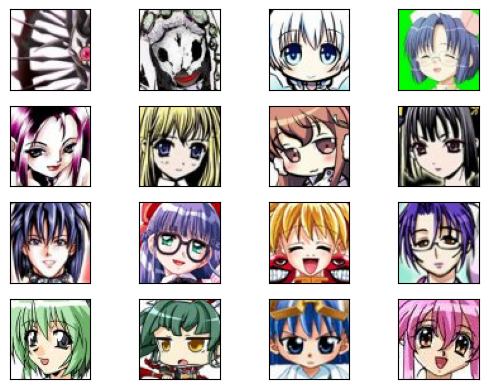

In [17]:
# example of bad data
w, h = 4, 4
for x in range(w):
    for y in range(h):
        plt.subplot(h, w, x * h + y + 1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(plt.imread(f'faces/{original[x * h + y][1]}'))